## Imports

In [1]:
import numpy as np
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(1)

## Function data

In [2]:
x = np.arange(-3, 3, 0.01)
y = np.sin(x)

## MLP

19/19 [==============================] - 0s 1ms/step


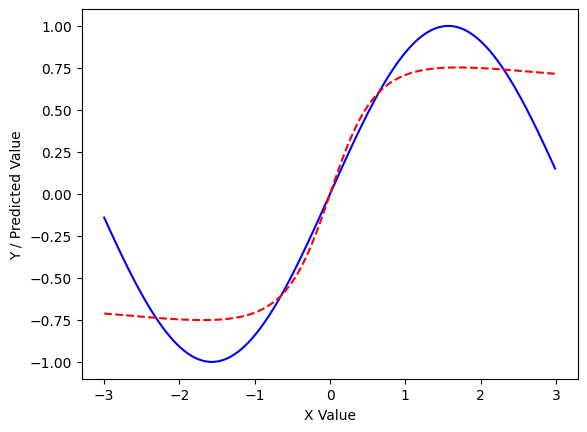

In [3]:
model = Sequential()
model.add(Dense(5, input_shape=(1,), activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.fit(x, y, epochs=50, batch_size=30, verbose=0)

y_predict = model.predict(x)

plt.plot(x, y, 'b', x, y_predict, 'r--')
plt.ylabel('Y / Predicted Value')
plt.xlabel('X Value')
plt.show()

## Radial Basis Function (RBF) Network

### K-means clustering

In [4]:
def kmeans(X, k):
  clusters = np.random.choice(np.squeeze(X), size=k)
  prevClusters = clusters.copy()
  stds = np.zeros(k)
  converged = False

  while not converged:
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    for i in range(k):
      pointsForCluster = X[closestCluster == i]
      if len(pointsForCluster) > 0:
        clusters[i] = np.mean(pointsForCluster, axis=0)

    converged = np.linalg.norm(clusters - prevClusters) < 1e-6
    prevClusters = clusters.copy()

  distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
  closestCluster = np.argmin(distances, axis=1)

  clustersWithNoPoints = []
  for i in range(k):
    pointsForCluster = X[closestCluster == i]
    if len(pointsForCluster) < 2:
      clustersWithNoPoints.append(i)
      continue
    else:
      stds[i] = np.std(X[closestCluster == i])

  if len(clustersWithNoPoints) > 0:
    pointsToAverage = []
    for i in range(k):
      if i not in clustersWithNoPoints:
        pointsToAverage.append(X[closestCluster == i])

    pointsToAverage = np.concatenate(pointsToAverage).ravel()
    stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

  return clusters, stds

### Model

In [5]:
def rbf(x, center, radius):
  return np.exp(-1 / (2 * radius ** 2) * (x - center) ** 2)

In [6]:
class RBF:
  def __init__(self, k):
    self.k = k
    self.w = np.random.randn(k)
    self.b = np.random.randn(1)

    self.centers = None
    self.stds = None

    self.iterations = None
    self.learning_rate = None

  def predict(self, x):
    y_predict = []
    for i in range(x.shape[0]):
      z = np.array([rbf(x[i], center, sigma) for center, sigma, in zip(self.centers, self.stds)])
      a = z.T.dot(self.w) + self.b
      y_predict.append(a)
    return np.array(y_predict)


  def update_parameters(self, a, error):
    self.w = self.w - self.learning_rate * a * error
    self.b = self.b - self.learning_rate * error


  def fit(self, x, y, iterations, learning_rate):
    self.iterations = iterations
    self.learning_rate = learning_rate
    self.centers, self.stds = kmeans(x, self.k)

    # Stochastic Gradient Descent
    for i in range(self.iterations):
      for j in range(x.shape[0]):

        # Forward propagation
        z = np.array([rbf(x[j], center, sigma) for center, sigma, in zip(self.centers, self.stds)])
        a = z.T.dot(self.w) + self.b

        # Backward propagation
        difference = y[j] - a
        error = (-1) * difference.flatten()

        # Update parameters
        self.update_parameters(z, error)

### Train RBF model

In [7]:
ITERATIONS = 500
LEARNING_RATE = 0.01

my_rbf = RBF(k=2)
my_rbf.fit(x, y, ITERATIONS, LEARNING_RATE)

y_predict = my_rbf.predict(x)

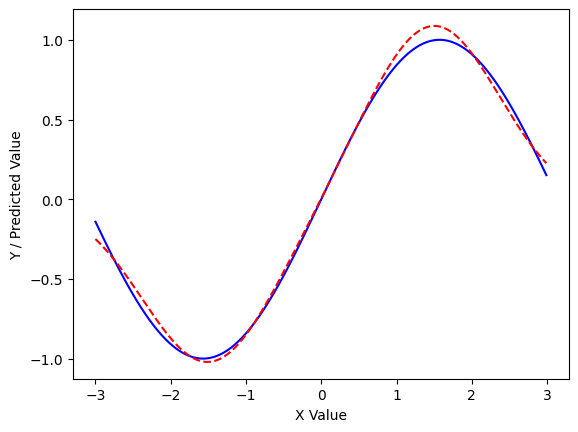

In [8]:
plt.plot(x, y, 'b', x, y_predict, 'r--')
plt.ylabel('Y / Predicted Value')
plt.xlabel('X Value')
plt.show()

## Comparison of MLP and RBF

25/25 [==============================] - 0s 2ms/step


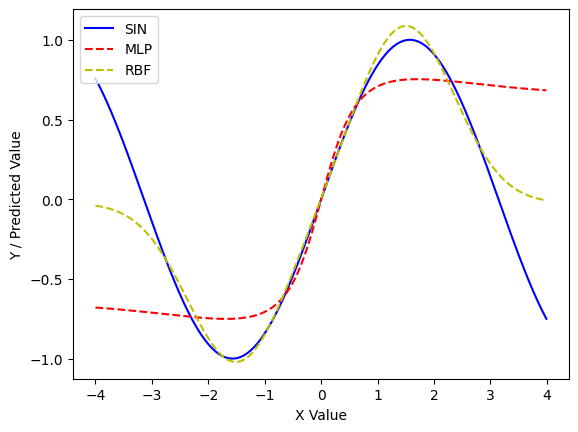

In [9]:
x_new = np.arange(-4, 4, 0.01)
y_new = np.sin(x_new)

y_mlp = model.predict(x_new)
y_rbf = my_rbf.predict(x_new)

plt.plot(x_new, y_new, 'b', x_new, y_mlp, 'r--', x_new, y_rbf, 'y--')
plt.ylabel('Y / Predicted Value')
plt.xlabel('X Value')
plt.legend(['SIN', 'MLP', 'RBF'], loc='upper left')
plt.show()